In [34]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pickle
import cv2
import tensorflow as tf
import seaborn as sns
from sklearn.svm import SVC

In [2]:
# data_dir = r"D:\Datasets\Custom Dataset Major"
data_dir = r"C:\Users\PRANAY KUMAR\OneDrive\Desktop\new data"
labels = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'plus', 'minus', 'mul','root','ob','cb']
labels2 = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ob','cb', 'n', 'c', 't', 'a', 'e']
data = []
target = []

data_filename='major_data_new.pkl'
if os.path.exists(data_filename):
    with open(data_filename, 'rb') as file:
        data,target = pickle.load(file)
else:
    for label in labels:
        label_dir = os.path.join(data_dir, label)

        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(label_dir, filename)

                img = Image.open(img_path)
                img = img.convert('L')
                img = img.resize((128, 128))

                img_data = np.array(img)

                data.append(img_data)
                target.append(label)
    with open(data_filename, 'wb') as file:
        pickle.dump((data,target), file)

In [3]:
data = np.array(data)
target = np.array(target)

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = x_train.reshape(-1, 128, 128, 1)
x_test = x_test.reshape(-1, 128, 128, 1)


with open('label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label_encoder, le_file)

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)
    
num_classes = len(label_encoder.classes_)

In [4]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [5]:
if os.path.exists('major_model_new.h5'):  
    model = tf.keras.models.load_model('major_model_new.h5')
else:
    history = model.fit(x_train, y_train_encoded, epochs=10, validation_data=(x_test, y_test_encoded))
    print(history.history)

    model.save('major_model_new.h5')

test_loss, test_accuracy = model.evaluate(x_test, y_test_encoded)
print(f'Test accuracy: {test_accuracy}')

190/190 [==============================] - 49s 252ms/step - loss: 0.0839 - accuracy: 0.9707
Test accuracy: 0.9707140326499939


In [17]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(x_train.reshape(x_train.shape[0], -1), y_train_encoded)
svm_accuracy = svm_model.score(x_test.reshape(x_test.shape[0], -1), y_test_encoded)
print("SVM Accuracy:", svm_accuracy)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train.reshape(x_train.shape[0], -1), y_train_encoded)
rf_accuracy = rf_model.score(x_test.reshape(x_test.shape[0], -1), y_test_encoded)
print("Random Forest Accuracy:", rf_accuracy)

# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(x_train.reshape(x_train.shape[0], -1), y_train_encoded)
knn_accuracy = knn_model.score(x_test.reshape(x_test.shape[0], -1), y_test_encoded)
print("KNN Accuracy:", knn_accuracy)


In [18]:
print("CNN Accuracy:", test_accuracy)
print("SVM Accuracy:", svm_accuracy)
print("RF Accuracy:", rf_accuracy)
print("KNN Accuracy:", knn_accuracy)

In [19]:
models = ['CNN', 'SVM', 'Random Forest', 'KNN']
accuracies = [test_accuracy, svm_accuracy, rf_accuracy, knn_accuracy]

plt.bar(models, accuracies)
plt.ylim(0.7, 1.0)  # Set y-axis limits
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.show()

190/190 [==============================] - 32s 165ms/step


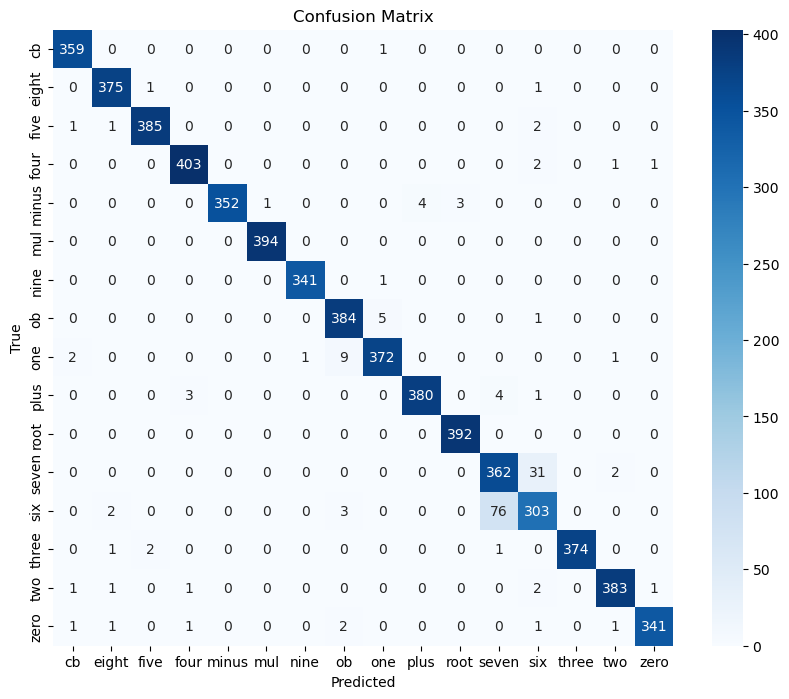

In [6]:
# Predict probabilities for the test set
y_pred_prob = model.predict(x_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Plot model accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()